In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [2]:
df = pd.read_csv("DbSalesModified.csv")
df.head()


,IdSale,SaleNumber,IdCompany,CreateDate,TotalSale,IdWarehouse,IdBranchCompany,IdDocument,IdSaleDetails,IdProduct,Quantity,UnitPrice,NameProduct
0,5628649,14206,150,2023-01-02,13500.0,258,230,8,9830106,184997,1,13500,Miel de abejas 375g
1,5629182,14207,150,2023-01-02,25920.0,258,230,8,9831029,298297,1,27000,Erogan 500ml
2,5629298,14208,150,2023-01-02,42000.0,258,230,8,9831277,298298,1,42000,Erogan 30 capsulas
3,5629327,14209,150,2023-01-02,15000.0,258,230,8,9831324,185065,1,15000,Bon rescate 25ml
4,5629753,14210,150,2023-01-02,46000.0,258,230,8,9832036,192777,1,46000,Mach 550ml


In [3]:
cols_to_drop = [
    "IdSale",
    "SaleNumber",
    "IdDocument",
    "IdSaleDetails",
    "NameProduct",
    "TotalSale"
]

df = df.drop(columns=cols_to_drop)


In [4]:
df.head()

,IdCompany,CreateDate,IdWarehouse,IdBranchCompany,IdProduct,Quantity,UnitPrice
0,150,2023-01-02,258,230,184997,1,13500
1,150,2023-01-02,258,230,298297,1,27000
2,150,2023-01-02,258,230,298298,1,42000
3,150,2023-01-02,258,230,185065,1,15000
4,150,2023-01-02,258,230,192777,1,46000


In [5]:
df["CreateDate"] = pd.to_datetime(df["CreateDate"])

In [6]:
df["year_month"] = df["CreateDate"].dt.to_period('M')


In [7]:
df_monthly =(df.groupby(
    [
    "year_month",
    "IdCompany",
    "IdProduct",
    "IdBranchCompany",
    "IdWarehouse"
    ],
    as_index=False
).agg({
        "Quantity": "sum",
        "UnitPrice": "mean"
    }
))

In [8]:
df_monthly["date"]=df_monthly["year_month"].dt.to_timestamp()

In [9]:
df_monthly["Month"]= df_monthly["year_month"].dt.month
df_monthly["Year"]= df_monthly["year_month"].dt.year

In [10]:
df_monthly.head()

,year_month,IdCompany,IdProduct,IdBranchCompany,IdWarehouse,Quantity,UnitPrice,date,Month,Year
0,2023-01,150,184860,230,258,2,31000.0,2023-01-01,1,2023
1,2023-01,150,184865,230,258,1,37000.0,2023-01-01,1,2023
2,2023-01,150,184872,230,258,1,56000.0,2023-01-01,1,2023
3,2023-01,150,184873,230,258,1,42000.0,2023-01-01,1,2023
4,2023-01,150,184874,230,258,1,31500.0,2023-01-01,1,2023


In [11]:
df_monthly = df_monthly[df_monthly["UnitPrice"] > 1]

# Transformaciones 

In [12]:
df_monthly["Quantity_log"]=np.log1p(df_monthly["Quantity"])
df_monthly["UnitPrice_log"]=np.log1p(df_monthly["UnitPrice"])

# Lags

In [13]:
group_cols=["IdCompany","IdProduct","IdBranchCompany","IdWarehouse"]

df_monthly=df_monthly.sort_values("date")

df_monthly["lag_1"]=df_monthly.groupby(group_cols)["Quantity_log"].shift(1)
df_monthly["lag_3"]=df_monthly.groupby(group_cols)["Quantity_log"].shift(3)
df_monthly["lag_6"]=df_monthly.groupby(group_cols)["Quantity_log"].shift(6)



# Rolling Back

In [14]:
df_monthly["roll_3"] = df_monthly.groupby(group_cols)["Quantity_log"].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df_monthly["roll_6"] = df_monthly.groupby(group_cols)["Quantity_log"].transform(
    lambda x: x.shift(1).rolling(window=6, min_periods=1).mean()
)

df_monthly["roll_12"] = df_monthly.groupby(group_cols)["Quantity_log"].transform(
    lambda x: x.shift(1).rolling(window=12, min_periods=1).mean()
)

In [15]:
df_monthly=df_monthly.dropna().reset_index(drop=True)

# Target encoding

In [16]:
split_date = "2025-01-01" 
Target="Quantity_log"

train = df_monthly[df_monthly["date"] < split_date].copy()
test = df_monthly[df_monthly["date"] >= split_date].copy()

global_mean=train[Target].mean()

def smoothed_target_encode(train, test, col, target, global_mean, m=15):
    agg = train.groupby(col)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    
    smooth = (counts * means + m * global_mean) / (counts + m)
    
    train[col + "_te"] = train[col].map(smooth).fillna(global_mean)
    test[col + "_te"] = test[col].map(smooth).fillna(global_mean)
    return train, test

for col in group_cols:
    train, test = smoothed_target_encode(train, test, col, Target, global_mean)

In [17]:
train.columns

Index(['year_month', 'IdCompany', 'IdProduct', 'IdBranchCompany',
       'IdWarehouse', 'Quantity', 'UnitPrice', 'date', 'Month', 'Year',
       'Quantity_log', 'UnitPrice_log', 'lag_1', 'lag_3', 'lag_6', 'roll_3',
       'roll_6', 'roll_12', 'IdCompany_te', 'IdProduct_te',
       'IdBranchCompany_te', 'IdWarehouse_te'],
      dtype='object')

# Configurar modelo 

In [18]:
feature = [
    #Date features
    "Month","Year",

    #Target encoded features
    "IdCompany_te","IdProduct_te","IdBranchCompany_te","IdWarehouse_te",

    #Lag features and rolling means
    "lag_1","lag_3","lag_6",
    "roll_3","roll_6","roll_12",

    #Quantitive features with log transformation
    "UnitPrice_log"

]
X_train = train[feature]
y_train = train[Target]

X_test = test[feature]
y_test = test[Target]

In [19]:
lgbm = lgb.LGBMRegressor(random_state=42, importance_type='gain')

param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [10, 15],
    'num_leaves': [31, 64],
    'reg_lambda': [0.1, 0.5],
    'min_child_samples': [20, 50]
}
tscv = TimeSeriesSplit(n_splits=3)

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=tscv, 
    scoring='r2',
    verbose=1,
    n_jobs=-1 # Usa todos los núcleos de tu procesador
)

# Entrenamiento

In [20]:
grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1159
[LightGBM] [Info] Number of data points in the train set: 2370, number of used features: 10
[LightGBM] [Info] Start training from score 1.171627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

# Predicciones

In [21]:
y_train_pred_log = best_model.predict(X_train)
y_test_pred_log  = best_model.predict(X_test)

y_train_real = np.expm1(y_train)
y_train_pred_real = np.expm1(y_train_pred_log)

y_test_real = np.expm1(y_test)
y_test_pred_real = np.expm1(y_test_pred_log)


# Train

In [22]:
train_mae = mean_absolute_error(y_train_real, y_train_pred_real)
train_rmse = mean_squared_error(y_train_real, y_train_pred_real, squared=False)
train_r2 = r2_score(y_train_real, y_train_pred_real)


c:\Users\Johan Suarez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Test

In [23]:
test_mae = mean_absolute_error(y_test_real, y_test_pred_real)
test_rmse = mean_squared_error(y_test_real, y_test_pred_real, squared=False)
test_r2 = r2_score(y_test_real, y_test_pred_real)


c:\Users\Johan Suarez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:

print("TRAIN")
print(f"MAE : {train_mae:,.2f} unidades")
print(f"RMSE: {train_rmse:,.2f} unidades")
print(f"R²  : {train_r2:.4f}")


print("TEST")
print(f"MAE : {test_mae:,.2f} unidades")
print(f"RMSE: {test_rmse:,.2f} unidades")
print(f"R²  : {test_r2:.4f}")


TRAIN
MAE : 1.23 unidades
RMSE: 6.96 unidades
R²  : 0.7024
TEST
MAE : 1.29 unidades
RMSE: 3.68 unidades
R²  : 0.8169


# Importacia de variables

C:\Users\Johan Suarez\AppData\Local\Temp\ipykernel_15548\4001095313.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Porcentaje', y='Variable', data=importancia, palette='viridis')


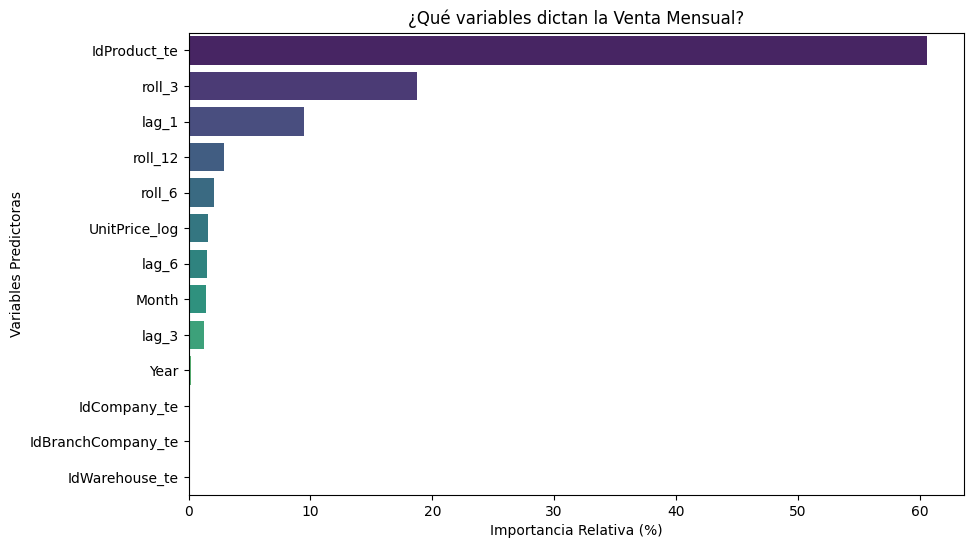

              Variable      Ganancia  Porcentaje
3         IdProduct_te  25751.167137   60.562493
9               roll_3   7974.251614   18.754123
6                lag_1   4043.491318    9.509624
11             roll_12   1247.588427    2.934122
10              roll_6    893.536722    2.101451
12       UnitPrice_log    695.303369    1.635239
8                lag_6    646.305918    1.520005
0                Month    624.440447    1.468581
7                lag_3    545.996495    1.284094
1                 Year     97.910186    0.230269
2         IdCompany_te      0.000000    0.000000
4   IdBranchCompany_te      0.000000    0.000000
5       IdWarehouse_te      0.000000    0.000000


In [25]:
importancia = pd.DataFrame({
    'Variable': feature,
    'Ganancia': best_model.feature_importances_
}).sort_values(by='Ganancia', ascending=False)

importancia['Porcentaje'] = (importancia['Ganancia'] / importancia['Ganancia'].sum()) * 100


plt.figure(figsize=(10, 6))
sns.barplot(x='Porcentaje', y='Variable', data=importancia, palette='viridis')
plt.title('¿Qué variables dictan la Venta Mensual?')
plt.xlabel('Importancia Relativa (%)')
plt.ylabel('Variables Predictoras')
plt.show()

print(importancia)

In [26]:
test['Error_Absoluto'] = np.abs(y_test_real - y_test_pred_real)
# Ver los 10 productos donde el modelo falla más
top_errores = test.groupby('IdProduct')['Error_Absoluto'].mean().sort_values(ascending=False).head(10)
print("Productos con mayor error promedio:\n", top_errores)

Productos con mayor error promedio:
 IdProduct
187351    57.656720
185085    25.270950
184912     8.321489
304066     7.533529
270591     6.207057
192990     4.646046
198794     4.625793
185080     4.560741
187597     4.524401
251073     4.436756
Name: Error_Absoluto, dtype: float64


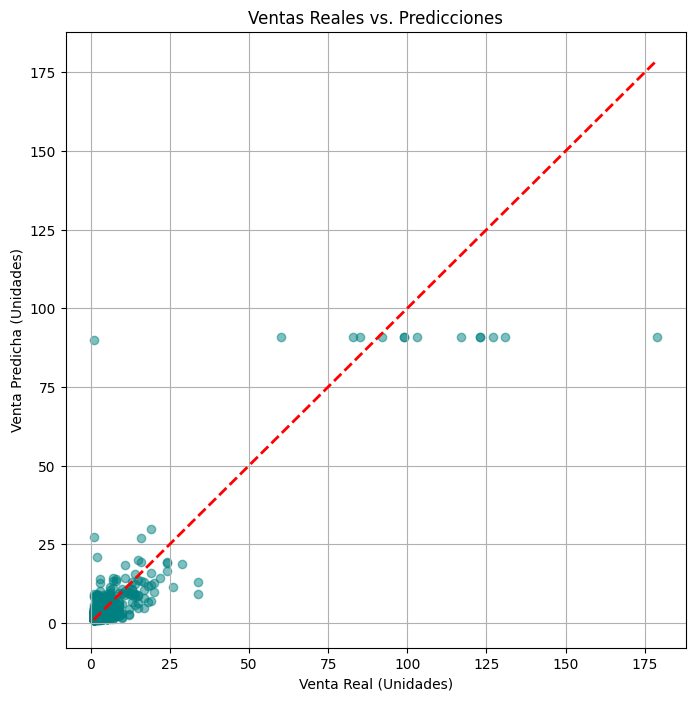

In [27]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_real, y_test_pred_real, alpha=0.5, color='teal')
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', lw=2)
plt.title('Ventas Reales vs. Predicciones')
plt.xlabel('Venta Real (Unidades)')
plt.ylabel('Venta Predicha (Unidades)')
plt.grid(True)
plt.show()

In [ ]:
# Asegurarnos de usar solo las filas de 'test' que realmente tienen predicciones
# Creamos una copia para no afectar el dataframe original
test_view = test.copy()

# Si y_test_pred_real salió de X_test, entonces usamos el índice de X_test
comparativa = pd.DataFrame({
    'Fecha': test_view.loc[X_test.index, 'date'],
    'Producto': test_view.loc[X_test.index, 'IdProduct'],
    'Bodega': test_view.loc[X_test.index, 'IdWarehouse'],
    'Real': y_test_real.values,      # Esto tiene longitud 2192
    'Predicho': y_test_pred_real     # Esto tiene longitud 2192
})

comparativa
# Calcular la diferencia (Error)
comparativa['Diferencia'] = comparativa['Real'] - comparativa['Predicho']
comparativa['Error_Abs'] = np.abs(comparativa['Diferencia'])
comparativa['Sugerencia_Compra'] = np.ceil(comparativa['Predicho'])

comparativa.to_csv("comparativa_ventas_mensuales.csv", index=False)